# Packages

In [1]:
# data preprocessing
import pandas as pd
import os
import shutil
import zipfile

# data visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# data modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression


# Data preparation

To make the most of this notebook, it's recommended to have the Kaggle API activated. Otherwise, you can download the latest version of the dataset directly from the Kaggle page and store it in a folder named "raw_data". You can find the dataset at this link: [Top Spotify Songs in 73 Countries (Daily Updated)](https://www.kaggle.com/datasets/asaniczka/top-spotify-songs-in-73-countries-daily-updated)


### Kaggle API procedure

In [2]:
#Download the latest version of the dataset
!kaggle datasets download -d asaniczka/top-spotify-songs-in-73-countries-daily-updated

100%|██████████████████████████████████████| 32.0M/32.0M [00:10<00:00, 3.70MB/s]
100%|██████████████████████████████████████| 32.0M/32.0M [00:10<00:00, 3.32MB/s]


In [3]:
# Search for a ZIP file in the current directory
zip_files = [f for f in os.listdir() if f.endswith(".zip")]

if not zip_files:
    print("No ZIP file found in the current directory.")
    exit(1)

# Create the raw_data folder if it doesn't exist
raw_data_folder = "raw_data"
os.makedirs(raw_data_folder, exist_ok=True)

# Decompress the ZIP file and move its contents into the raw_data folder
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(raw_data_folder)

    # Optionally, move the ZIP file itself into the raw_data folder
    shutil.move(zip_file, os.path.join(raw_data_folder, zip_file))

print("ZIP file(s) decompressed and moved into the raw_data folder.")


ZIP file(s) decompressed and moved into the raw_data folder.


### Dataset loading (assuming that a .csv file is present in the raw_data folder)

In [4]:
#Load the dataset into a pandas dataframe
df = pd.read_csv('raw_data/universal_top_spotify_songs.csv')
#drop the null values
df.dropna(inplace=True)
#drop the duplicate rows
df.drop_duplicates(inplace=True)
#reset the index
df.reset_index(inplace=True)
#show the first 5 rows of the dataframe
df.head()

,index,spotify_id,name,artists,daily_rank,daily_movement,weekly_movement,country,snapshot_date,popularity,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,50,6Kijtp0DB6VwcoJIw7PJ9W,"Imithandazo (feat. Young Stunna, DJ Maphorisa,...","Kabza De Small, Mthunzi, DJ Maphorisa, Young S...",1,0,0,ZA,2024-02-06,73,...,6,-9.686,0,0.1120,0.1790,0.001260,0.1820,0.795,113.001,4
1,51,5CD3ImPPdCW8QFQkjo5TXt,Funk 55,"Shakes & Les, DBN Gogo, Zee Nxumalo, Ceeka RSA...",2,0,0,ZA,2024-02-06,69,...,2,-13.307,0,0.0830,0.0230,0.000359,0.0425,0.508,113.047,4
2,52,4tsVMjM60RNTe9EV5oQ4sQ,Masithokoze,"DJ Stokie, Eemoh",3,0,1,ZA,2024-02-06,69,...,6,-14.253,0,0.0617,0.0224,0.155000,0.0154,0.355,113.006,4
3,53,0UBK6HcgmmWUQzFQTncmDz,Keneilwe (feat. Dalom Kids),"Wanitwa Mos, Nkosazana Daughter, Master KG, Da...",4,0,-1,ZA,2024-02-06,69,...,9,-8.306,1,0.0467,0.0102,0.001240,0.0228,0.589,113.015,4
4,54,3pImmSzeKex5ffzsDoaL3z,Izenzo,"Bassie, Aymos, T-Man SA",5,0,0,ZA,2024-02-06,68,...,4,-13.918,0,0.0563,0.5750,0.001170,0.1410,0.492,112.000,4


### Feature selection and trasforming

In [5]:
def top_what(row):
    '''this function returns the category of the song based on its daily rank'''
    if row.daily_rank <= 20:
        cat = 'top20'
    else:
        cat = 'average'
    return cat

In [6]:
#apply the function to the dataframe
df['target']=df.apply(top_what, axis = 1)

In [7]:
#drop the columns that are not needed
df = df[['is_explicit', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature', 'target']]

# Preprocessing

In [8]:
#Create the feature matrix and the target variable
X = df[df.columns[:-1]]
y=df[df.columns[-1]]

In [9]:
# Instantiate the LabelEncoder
label_encoder = LabelEncoder()

# Fit it to the target
label_encoder.fit(y)

# Find the encoded classes
print(f"The Label Encoder has encoded the penguin classes into {label_encoder.classes_}")

# Transform the targets
encoded_target = label_encoder.transform(y)

The Label Encoder has encoded the penguin classes into ['average' 'top20']


In [10]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, encoded_target , test_size=0.3, random_state=88)

<Axes: xlabel='count', ylabel='target'>

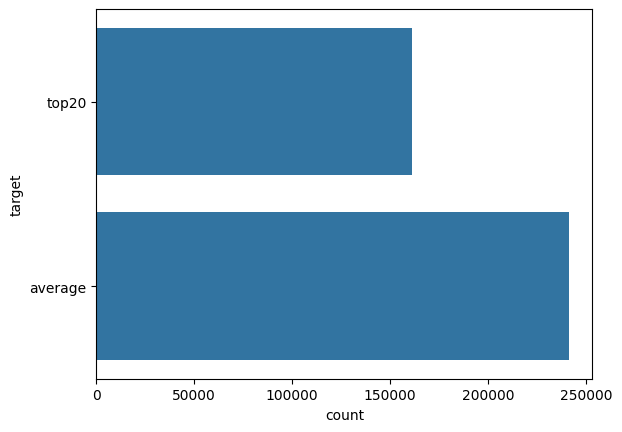

In [11]:
#check the balance of the target variable
sns.countplot(y)

# Data Modeling

### Baseline model

In [12]:
# Create a pipeline
num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
num_col = make_column_selector(dtype_include=['float64', 'int64'])

cat_transformer = OneHotEncoder(sparse_output=False)
cat_col = make_column_selector(dtype_include=['object', 'bool'])

preproc_basic = make_column_transformer(
    (num_transformer, num_col),
    (cat_transformer, cat_col),
    remainder='passthrough'
)

# Alternative to PCA, tSNE
svd = TruncatedSVD(n_components=10)

# Basic classifier (e.g., Logistic Regression)
basic_clf = LogisticRegression()

base_pipeline = make_pipeline(preproc_basic, svd, basic_clf)

base_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162917b20>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162917640>)])),
                ('truncatedsvd', TruncatedSVD(n_components=10)),
                ('logisticregression', LogisticRegression())])

In [13]:
# Fit the model
base_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162917b20>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162917640>)])),
                ('truncatedsvd', TruncatedSVD(n_components=10)),
                ('logisticregression', LogisticRegression())])

In [14]:
# cross validation
cross_val_score(base_pipeline, X_train, y_train, cv=5,n_jobs=-1, scoring='accuracy').mean()

0.6030871688661437

### Improve the pipeline with an XGBClassifier

In [25]:
#Create a pipeline
num_transformer = make_pipeline(SimpleImputer(), StandardScaler())
num_col = make_column_selector(dtype_include=['float64', 'int64'])

cat_transformer = OneHotEncoder(sparse_output=False)
cat_col = make_column_selector(dtype_include=['object','bool'])

preproc_basic = make_column_transformer(
    (num_transformer, num_col),
    (cat_transformer, cat_col),
    remainder='passthrough'
)
#Alternative to PCA, tSNE
svd = TruncatedSVD(n_components=5)

xgb_clas = XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.1, random_state=88, verbosity=1, n_jobs=-1)

XGB_pipeline = make_pipeline(preproc_basic,svd, xgb_clas)

XGB_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162d11f90>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  <sklearn.compose._column_t...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, random_state=88, ...))])

In [26]:
# Fit the model
XGB_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x162d11f90>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False),
                                                  <sklearn.compose._column_t...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, random_state=88, ...))])

In [27]:
# cross validation
cross_val_score(XGB_pipeline, X_train, y_train, cv=5,n_jobs=-1, scoring='accuracy').mean()

0.7744714197265008

### Improve the score with a Random Search 

In [28]:
# Define the parameter grid for random search
param_distributions = {
    'xgbclassifier__colsample_bytree': [0.4, 0.5, 0.6, 0.7],  # Additional values
    'xgbclassifier__gamma': [0.1, 0.2, 0.3, 0.4],  # Additional values
    'xgbclassifier__max_depth': [10, 15, 20, 25],  # Additional values
    'xgbclassifier__min_child_weight': [1, 2, 3, 4],  # Additional values
    'xgbclassifier__n_estimators': [50, 100, 150, 200],  # Additional values
    'xgbclassifier__reg_alpha': [0, 0.1, 0.5, 1],  # Additional values
    'xgbclassifier__reg_lambda': [2, 2.5, 3, 3.5],  # Additional values
    'xgbclassifier__tree_method': ['approx', 'auto', 'hist']  # Additional values
}


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=XGB_pipeline,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random parameter combinations to try
    scoring='accuracy',  # Use appropriate scoring metric
    cv=5,  # Number of folds for cross-validation
    verbose=1,  # Verbosity level
    n_jobs=-1  # Use all available CPU cores
)

# Perform the random search
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer()),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x162d11f90>),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(sparse_output...
                                                                            0.5,
                                                                            0.6,
                                                                            0.7],
                                        'xgbclassifier__gamma': [0.1, 0.2, 0.3,
                                                                 0.4],
                                        'xgbclassifier__max_depth': [10, 15, 20,
                                                                     25],
                                        'xgbclassifier__min_child_weight': [1,
                                                                            2,
                                                                            3,
                                                                            4],
                                        'xgbclassifier__n_estimators': [50, 100,
                                                                        150,
                                                                        200],
                                        'xgbclassifier__reg_alpha': [0, 0.1,
                                                                     0.5, 1],
                                        'xgbclassifier__reg_lambda': [2, 2.5, 3,
                                                                      3.5],
                                        'xgbclassifier__tree_method': ['approx',
                                                                       'auto',
                                                                       'hist']},
                   scoring='accuracy', verbose=1)

In [29]:
# Access the best parameters and best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [30]:
best_params

{'xgbclassifier__tree_method': 'approx',
 'xgbclassifier__reg_lambda': 2,
 'xgbclassifier__reg_alpha': 0.5,
 'xgbclassifier__n_estimators': 50,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__max_depth': 25,
 'xgbclassifier__gamma': 0.2,
 'xgbclassifier__colsample_bytree': 0.4}

In [31]:
# Cross-validate Pipeline
cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs= -1).mean()

0.7784927533712411

# Visual Comparison of the results 

In [32]:
# Define function to plot confusion matrix for a given model
def plot_confusion_matrix(ax, model_name, model, X_test, y_test):
    ''' This function plots a confusion matrix for a given model.'''
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix as a heatmap
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", cbar=False,
                xticklabels=["Predicted average", "Predicted top20"],
                yticklabels=["Actual average", "Actual top20"], ax=ax)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix - " + model_name)


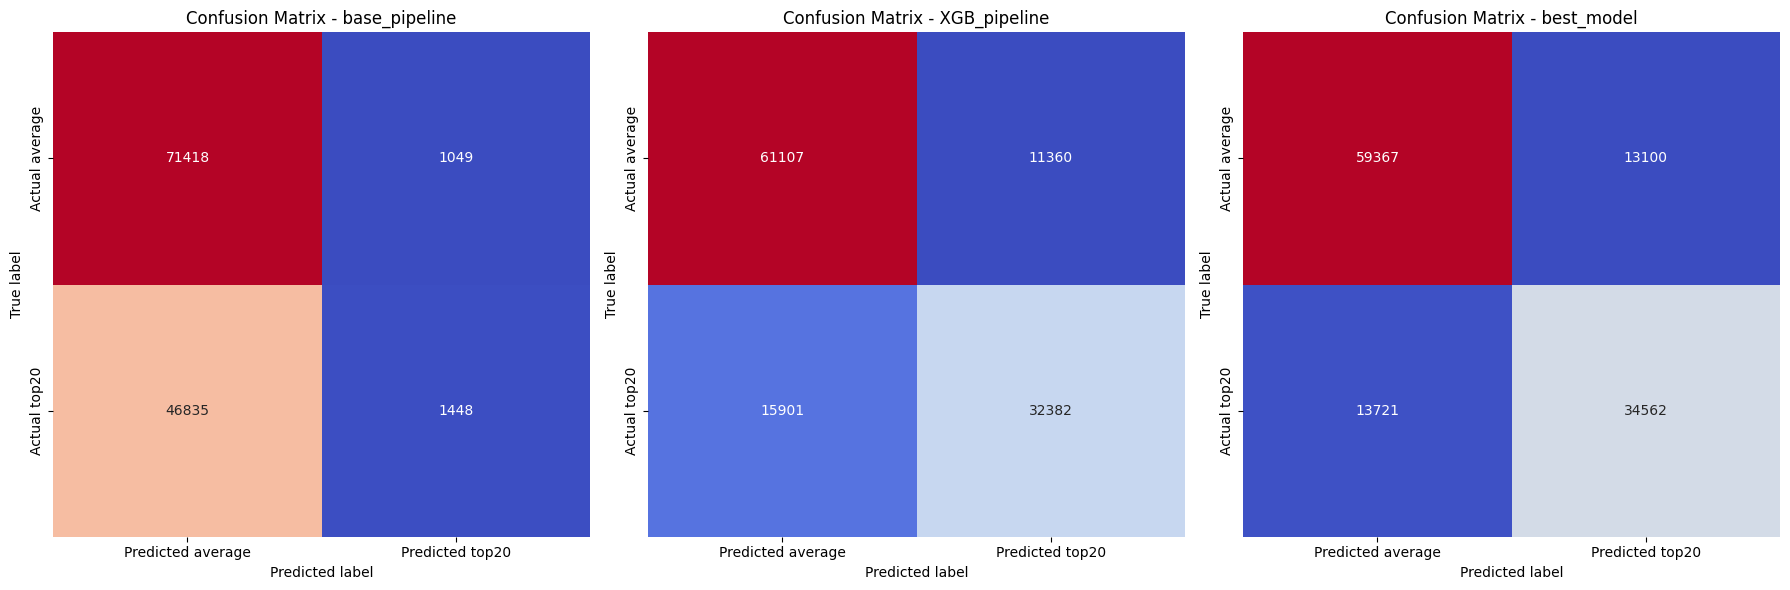

In [33]:
# Create subplots for each model
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot confusion matrix for each model
plot_confusion_matrix(axs[0], 'base_pipeline', base_pipeline, X_test, y_test)
plot_confusion_matrix(axs[1], 'XGB_pipeline' , XGB_pipeline, X_test, y_test)
plot_confusion_matrix(axs[2], 'best_model', best_model, X_test, y_test)

# Adjust layout and show plot
plt.tight_layout()
plt.show()
